ФИО: Дорожинский Владислав Игоревич

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable, grad
from utils import create_dataloader
from torch.utils.data import Dataset, DataLoader

from skimage import io
import numpy as np
from os import listdir
from os.path import isfile, join
import time

%matplotlib inline

In [2]:
def get_noise(bs=16, noise_size=50):
    return Variable(torch.FloatTensor(bs, noise_size).normal_(0, 1), requires_grad=False)

In [3]:
class DataAcc:
    def __init__(self, dataloader):
        self.dl = dataloader
        self.it = iter(self.dl)
        
    def reset(self):
        self.it = iter(self.dl)
    
    def get_next(self):
        res = None
        try:
            res = next(self.it)
        except:
            print('DataAcc reinit')
            self.reset()
            res = next(self.it)
        return res

# data_acc = DataAcc(dataloader)

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = '../data/mnist'
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100

### Create dataloder

In [3]:
dataloader = create_dataloader(config)

In [4]:
len(dataloader)

3750

In [5]:
for image, cat in dataloader:
    break

In [6]:
image.size()

torch.Size([16, 1, 28, 28])

### Create generator and discriminator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [8]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

### Create optimizers and loss

In [9]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

### Create necessary variables

In [10]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Имплементируйте GAN из статьи

2) Попробуйте LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Попробуйте оба GAN на CelebA http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

Обязательны графики.

### Main loop

#### GAN on MNIST

In [ ]:
criterion = nn.BCELoss()
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        images = Variable(images, requires_grad=False).view(-1, 784).cuda()
        loss = criterion(discriminator(images), Variable(torch.ones(config.batch_size, 1)).cuda())
        loss.backward()
        errD_x = loss.data[0]
        
        # fake
        fake_images = generator(get_noise().cuda()).detach()
        loss = criterion(discriminator(fake_images), Variable(torch.zeros(config.batch_size, 1)).cuda())
        loss.backward()
        errD_z = loss.data[0]
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        
        fake_images = generator(get_noise().cuda())
        loss = criterion(discriminator(fake_images), Variable(torch.ones(config.batch_size, 1)).cuda())
        loss.backward()
        errG = loss.data[0]
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x,
                                                                                            errD_z, 
                                                                                            errG))
    

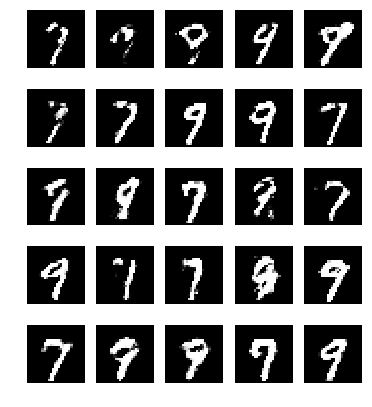

In [15]:
X = generator(get_noise(25).cuda()).data.cpu().numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

#### LSGAN on MNIST

In [20]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

optim_G = optim.Adam(params=generator.parameters(), lr=0.00004)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.00003)

In [ ]:
criterion = nn.MSELoss()
for iteration in range(3000):
    errD_x = 0
    errD_z = 0
    errG = 0
    for _ in range(3):
        ####### 
        # Discriminator stage: minimize (D(x) - 1)^2 + (D(G(z)))^2
        #######
        discriminator.zero_grad()
        images, _ = data_acc.get_next()
        # real
        images = Variable(images, requires_grad=False).view(-1, 784).cuda()
        loss = criterion(discriminator(images), Variable(torch.ones(config.batch_size, 1)).cuda())
        loss.backward()
        errD_x = loss.data[0]
        
        # fake
        fake_images = generator(get_noise().cuda()).detach()
        loss = criterion(discriminator(fake_images), Variable(torch.zeros(config.batch_size, 1)).cuda())
        loss.backward()
        errD_z = loss.data[0]
        
        optim_D.step()
        
    for _ in range(1):
        ####### 
        # Generator stage: minmize (D(G(x) - 1)^2
        #######
        generator.zero_grad()
        
        fake_images = generator(get_noise().cuda())
        loss = criterion(discriminator(fake_images), Variable(torch.ones(config.batch_size, 1)).cuda())
        loss.backward()
        errG = loss.data[0]
        
        optim_G.step()
        
    if (iteration+1) % 100 == 0:
        print('Iter:{} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(iteration+1,
                                                                                    errD_x,
                                                                                    errD_z, 
                                                                                    errG))

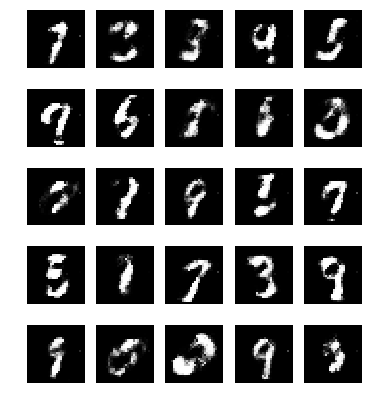

In [46]:
X = generator(get_noise(25).cuda()).data.cpu().numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

<hr>
# Progressive Growing of GANs for Improved Quality, Stability, and Variation
* http://research.nvidia.com/publication/2017-10_Progressive-Growing-of

* https://github.com/tkarras/progressive_growing_of_gans

In [4]:
class Timer:
    def __init__(self):
        self.last = time.time()
    
    def tick(self):
        delta = time.time() - self.last
        self.last = time.time()
        return delta

In [5]:
def mean_pool_nhwc(img, k):
    h, w = img.shape[:2]
    img = img.reshape(h // k, k, w // k, k, 3)
    img = np.mean(img, (1, 3))
    return img

def log2i(x):
    return x.bit_length() - 1

In [6]:
class Config:
    pass

config = Config()
config.noise_size = 256
config.batch_size = 16

In [7]:
TOWER_HEIGHT = 5
PRESERVE_CHANNELS = 0
R = TOWER_HEIGHT + 2 # at every stair resolution is doubled. Initial is 2 ^ 2 = 4
R, 2**R, config.noise_size / (2 ** (TOWER_HEIGHT - PRESERVE_CHANNELS))

(7, 128, 8.0)

In [8]:
def show(X, bs, figsize=(15, 15), square=False):
    nrows, ncols = 1, bs
    if square:
        side = int(np.sqrt(bs))
        assert side * side == bs
        nrows, ncols = side, side
    X = X.data.permute(0, 2, 3, 1).cpu().numpy()
    X = np.clip(X, 0, 1)
    plt.figure(figsize=figsize)
    for i in range(bs):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(X[i])
        plt.axis('off')
    plt.show()

def generate_demo(g, stairs, bs, ns, alpha=None):
    imsize = 2 ** (stairs + 2)
    g.eval()
    X = g(get_noise(bs, ns).cuda(), stairs, alpha).data.permute(0, 2, 3, 1).cpu().numpy()
    X = np.clip(X, 0, 1)
    plt.figure(figsize=(15, 7))
    for i in range(bs):
        plt.subplot(1, bs, i+1)
        plt.imshow(X[i].reshape(imsize, imsize, 3))
        plt.axis('off')
    plt.show()

In [9]:
class LRN(nn.Module):
    def __init__(self, eps=1e-8):
        super(LRN, self).__init__()
        self.eps = eps

    def forward(self, x):
        norm = torch.sum(x ** 2, 1, keepdim=True)
        return x / torch.sqrt(norm + self.eps)

In [10]:
img_root = '../../data/img_align_celeba'
imgs = sorted([f for f in listdir(img_root) if isfile(join(img_root, f))])

In [11]:
def load_tiny_img(path):
    image = io.imread(path)
    image = image[45:173, 25:153]
    image = mean_pool_nhwc(image, 4).astype(np.uint16)
    return image

In [12]:
class CelebA(Dataset):
    def __init__(self, imgs_path, imgs, preload=False):
        self.imgs_path = imgs_path
        self.imgs = imgs
        self.preloaded = None
        self.preload = preload
        if preload:
            t = Timer()
            self.preloaded = np.empty([len(imgs), 32, 32, 3], dtype=np.uint16)
#             self.preloaded_mask = np.zeros([len(imgs)], dtype=np.bool) 
            for i, pth in enumerate(imgs):
                img_name = join(self.imgs_path, pth)
                image = io.imread(img_name)
                image = image[45:173, 25:153]# / 256.0
                image = mean_pool_nhwc(image, 4)
                self.preloaded[i] = image
                if i % 50000 == 0:
                    print(i)
            print('Elapsed: {} s.'.format(t.tick()))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if self.preload:
#             if not self.preloaded_mask[idx]:
#                 img_name = join(self.imgs_path, self.imgs[idx])
#                 self.preloaded[idx] = load_tiny_img(img_name)
#                 self.preloaded_mask[idx] = 1
#                 print(np.sum(celeba_dataset.preloaded_mask))
            return (self.preloaded[idx] / 256.0).astype(np.float32)
        img_name = join(self.imgs_path, self.imgs[idx])
        image = io.imread(img_name)

        return (image[45:173, 25:153] / 256.0).astype(np.float32)

In [13]:
celeba_dataset = CelebA(img_root, imgs, preload=True)
celeba_dataloader = DataLoader(celeba_dataset, batch_size=config.batch_size,
                               shuffle=True, drop_last=True, num_workers=4)
data_acc = DataAcc(celeba_dataloader)

0
50000
100000
150000
200000
Elapsed: 280.7271318435669 s.


In [42]:
t = Timer()
for e in celeba_dataloader:
    pass
t.tick()

4.983246564865112

In [17]:
def he_init(w):
    nn.init.kaiming_normal_(w)
    
class WSConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(WSConv2d, self).__init__(in_channels, out_channels,
                                       kernel_size, stride=stride,
                                       padding=padding)
        he_init(self.weight.data)
        w = self.weight.data
        self.scale = np.sqrt(torch.mean(w ** 2).item())
        self.weight.data *= 1 / self.scale

    def forward(self, x):
        x = x * self.scale
        return super(WSConv2d, self).forward(x)
    
class WSLinear(nn.Linear):
    def __init__(self, in_features, out_features):
        super(WSLinear, self).__init__(in_features, out_features)
        he_init(self.weight.data)
        w = self.weight.data
        self.scale = np.sqrt(torch.mean(w ** 2).item())
        self.weight.data *= 1 / self.scale

    def forward(self, x):
        x = x * self.scale
        return super(WSLinear, self).forward(x)



class Generator(nn.Module):
    def __init__(self, noise_size):
        super(Generator, self).__init__()
        
        self.noise_size = noise_size
        
        self.first_block = nn.Sequential(
            WSConv2d(self.noise_size, self.noise_size, 4, stride=1, padding=3),
            nn.LeakyReLU(0.2),
            LRN(),
            WSConv2d(self.noise_size, self.noise_size, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            LRN()
        )
        
        size = self.noise_size
        iter_blocks = [None] * TOWER_HEIGHT
        to_rgb = [None] * (TOWER_HEIGHT + 1)
        to_rgb[0] = WSConv2d(size, 3, 1, stride=1, padding=0)
        for i in range(TOWER_HEIGHT):
            new_size = size // 2 if i >= PRESERVE_CHANNELS else size
            
            iter_blocks[i] = nn.Sequential(
                WSConv2d(size, new_size, 3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
                LRN(),
                WSConv2d(new_size, new_size, 3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
                LRN()
            )
            to_rgb[i + 1] = WSConv2d(new_size, 3, 1, stride=1, padding=0)
            size = new_size
            
        self.to_rgb = nn.ModuleList(to_rgb)
        self.iter_blocks = nn.ModuleList(iter_blocks)
        
        
    def forward(self, x, stairs, alpha=None):
        # noise on (N-1)D sphere
        x /= torch.sqrt(torch.sum(x**2, 1, keepdim=True))
        x = x.view(-1, self.noise_size, 1, 1)
        
        x = self.first_block(x)
        x_from_old = None
        for i in range(stairs):
            x = nn.Upsample(scale_factor=2)(x)
            
            if (alpha is not None) and (i == stairs-1):
                x_from_old = self.to_rgb[stairs-1](x)
                
            x = self.iter_blocks[i](x)
            
        if alpha is not None:
            x = self.to_rgb[stairs](x) * alpha + x_from_old * (1 - alpha)
        else:
            x = self.to_rgb[stairs](x)
        return x
    
    
class Discriminator(nn.Module):
    def __init__(self, noise_size):
        super(Discriminator, self).__init__()
        self.noise_size = noise_size
        
        from_rgb = [None] * (TOWER_HEIGHT + 1)
        iter_blocks = [None] * TOWER_HEIGHT
        size = noise_size // 2 ** (TOWER_HEIGHT - PRESERVE_CHANNELS)
        for i in range(TOWER_HEIGHT):
            from_rgb[i] = nn.Sequential(WSConv2d(3, size, 1), nn.LeakyReLU(0.2))
            
            new_size = size * 2 if i < (TOWER_HEIGHT - PRESERVE_CHANNELS) else size
            iter_blocks[i] = nn.Sequential(
                WSConv2d(size, size, 3, padding=1),
                nn.LeakyReLU(0.2),
                WSConv2d(size, new_size, 3, padding=1),
                nn.LeakyReLU(0.2),
                nn.AvgPool2d(2)
            )
            size = new_size
        from_rgb[-1] = nn.Sequential(WSConv2d(3, noise_size, 1), nn.LeakyReLU(0.2))
            
        self.from_rgb = nn.ModuleList(from_rgb)
        self.iter_blocks = nn.ModuleList(iter_blocks)
        
        self.final_conv = nn.Sequential(
            WSConv2d(self.noise_size+1, self.noise_size, 3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(self.noise_size, self.noise_size, 4),
            nn.LeakyReLU(0.2))
        
        self.pred = WSLinear(self.noise_size, 1)
        
    def forward(self, x, stairs, alpha=None):
        minibatch_std = torch.mean(torch.std(x, 0))
        
        x_from_old = None
        if alpha is not None:
            x_from_old = self.from_rgb[TOWER_HEIGHT - stairs + 1](nn.AvgPool2d(2)(x))
            
        x = self.from_rgb[TOWER_HEIGHT - stairs](x)
        
        for i in range(TOWER_HEIGHT - stairs, TOWER_HEIGHT):
            x = self.iter_blocks[i](x)
            if (alpha is not None) and (i == TOWER_HEIGHT - stairs):
                x = x * alpha + x_from_old * (1 - alpha)
                
        minibatch_std = Variable(torch.Tensor(x.size(0), 1, 4, 4).cuda().fill_(1.0)) * minibatch_std
        x = torch.cat([x, minibatch_std], 1)
        x = self.final_conv(x)
        x = x.view(-1, self.noise_size)
        x = self.pred(x)
        return x

In [18]:
def average_generator(gen, gen_av, decay=0.999):
    source_params = list(gen.parameters())
    av_params = list(gen_av.parameters())
    for i in range(len(av_params)):
        av_params[i].data *= decay
        av_params[i].data += (1.0 - decay) * source_params[i].data.cpu()

In [19]:
def save_checkpoint(state, path='checkpoints/', verbose=True):
    filename = path + str(state['stairs']) + '_' + str(state['stage']) + '_' + str(state['n_iter']) + '.pth.tar'
    if verbose:
        print('Saved checkpoint: ' + filename)
    torch.save(state, filename)

In [20]:
def gen_loss(g, d, gen_noise, stairs, alpha):
    # draw noise
    gen_noise.data.normal_()
    
    # get generated data
    gen_data = g(gen_noise, stairs, alpha)
    
    # feed data through discriminator
    disc_out = d(gen_data, stairs, alpha)
    
    # get loss
    loss = -disc_out.mean()
    
    return loss

def dis_loss(g, d, gen_noise, real_data, stairs, alpha, gp_alpha, lmb, iwass_epsilon=0.001):
    # draw noise
    gen_noise.data.normal_()
    
    # get generated data
    gen_data = g(gen_noise, stairs, alpha)
    
    # feed data through discriminator
    disc_out_gen = d(gen_data, stairs, alpha)
    disc_out_real = d(real_data, stairs, alpha)
    
    # get loss (w/o GP)
    loss = disc_out_gen.mean() - disc_out_real.mean()
    
    # draw interpolation values
    gp_alpha.uniform_()
    
    # interpolate between real and generated data
    interpolates = gp_alpha * real_data.data + (1 - gp_alpha) * gen_data.data
    interpolates = Variable(interpolates, requires_grad=True)
    
    # feed interpolates through discriminator
    disc_out_interp = d(interpolates, stairs, alpha)
    
    # get gradients of discriminator output with respect to input
    gradients = grad(outputs=disc_out_interp.sum(), inputs=interpolates,
                     create_graph=True)[0]
    
    # calculate gradient penalty
    grad_pen = ((gradients.view(gradients.size(0), -1).norm(2, dim=1) - 1)**2).mean()
    
    # add gradient penalty to loss
    loss += lmb * grad_pen
    
    # additional penalty term to keep the scores from drifting too far from zero
    loss += (disc_out_real ** 2).mean() * iwass_epsilon
    
    return loss

def train_discriminator(g, d, opt_d, gen_noise, gp_alpha, stairs, alpha=None):
    d.train()
    d.zero_grad()
    target_size = 2 ** (2 + stairs)
    
#     images = torch.from_numpy(celeba_dataset[0].reshape(1, 128, 128, 3))
#     images = images.repeat(config.batch_size, 1, 1, 1)
#     images = torch.from_numpy(np.zeros([config.batch_size, 128, 128, 3], dtype=np.float32))
    images = data_acc.get_next()
    this_size = images.size(1)
    images = images * 2 - 1
    images = Variable(images, requires_grad=False).permute(0, 3, 1, 2).cuda()
#     compression = int(np.log2(32)) - 2 - stairs
    images = nn.AvgPool2d(this_size // target_size)(images)
    
    loss = dis_loss(g, d, gen_noise, images, stairs, alpha, gp_alpha, 10.0)
    loss.backward()
        
    opt_d.step()
    
    return loss.data.cpu().item()

def train_generator(g, d, opt_g, gen_noise, stairs, alpha=None):
    g.train()
    g.zero_grad()
    
    loss = gen_loss(g, d, gen_noise, stairs, alpha)
    loss.backward()
        
    opt_g.step()
    
    return loss.data.cpu().item()

In [21]:
generator = Generator(config.noise_size).cuda()
generator_av = Generator(config.noise_size)
discriminator = Discriminator(config.noise_size).cuda()

optim_G = optim.Adam(params=generator.parameters(), lr=0.001, betas=(0, 0.99))
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.001, betas=(0, 0.99))

NOISE = get_noise(config.batch_size, config.noise_size).cuda()
GP_ALPHA = torch.Tensor(config.batch_size, 1, 1, 1).cuda()

In [22]:
600000 // config.batch_size

37500

In [23]:
stage = 1
n_iter = 35000
print_every = 1000
stairs = 0
start_from = 0

In [31]:
checkpoint_path = 'checkpoints/4_0_10.pth.tar'

checkpoint = torch.load(checkpoint_path)
stairs = checkpoint['stairs']
stage = checkpoint['stage']

generator.load_state_dict(checkpoint['gen'])
discriminator.load_state_dict(checkpoint['dis'])

optim_G.load_state_dict(checkpoint['optim_G'])
optim_D.load_state_dict(checkpoint['optim_D'])
            
n_iter = checkpoint['n_iter']
stairs = checkpoint['stairs']
print_every = checkpoint['print_every']
print('stairs: ' + str(stairs))
print('stage: ' + str(stage))
print('n_iter: ' + str(n_iter))
print('print_every: ' + str(print_every))

stairs: 4
stage: 0
n_iter: 10
print_every: 5


STAB. Iter:0 errD: 0.33 errG: -0.63 in 0.17


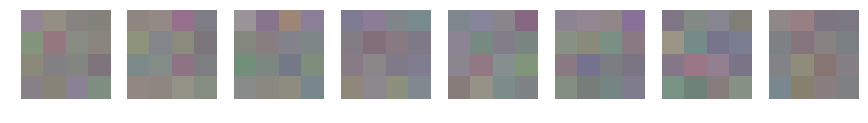

STAB. Iter:1000 errD: -0.43 errG: 0.84 in 25.65


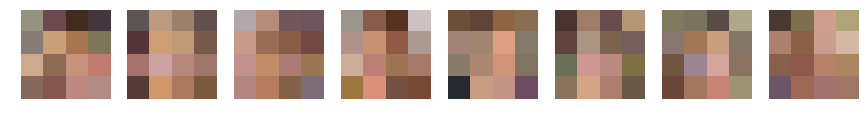

STAB. Iter:2000 errD: -0.19 errG: 0.03 in 25.48


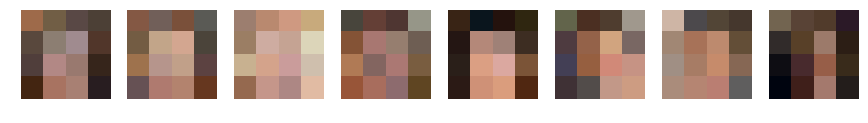

STAB. Iter:3000 errD: 0.08 errG: 0.22 in 26.48


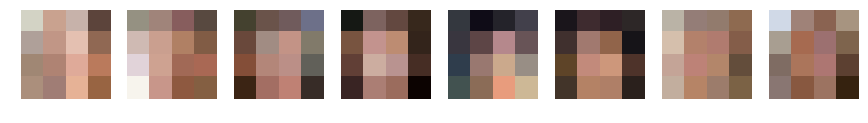

STAB. Iter:4000 errD: -0.04 errG: 0.21 in 25.45


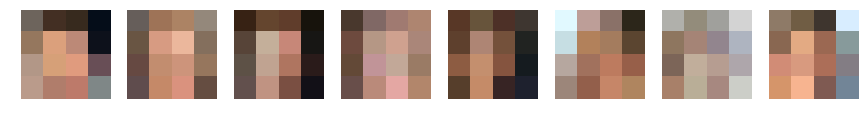

STAB. Iter:5000 errD: -0.13 errG: -0.15 in 28.53


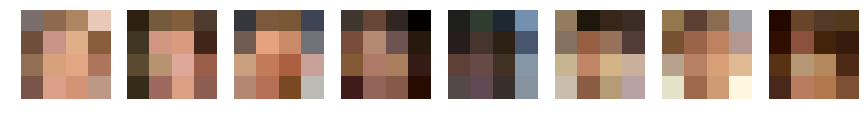

STAB. Iter:6000 errD: -0.12 errG: 0.10 in 28.40


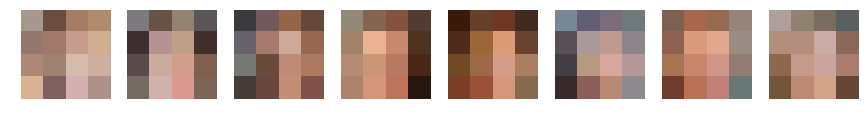

STAB. Iter:7000 errD: 0.05 errG: -0.03 in 27.91


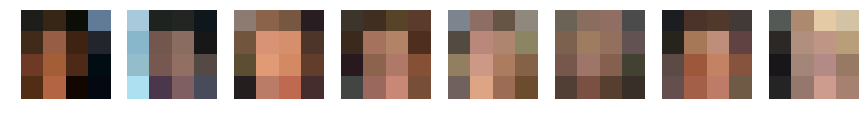

STAB. Iter:8000 errD: -0.23 errG: -0.15 in 28.80


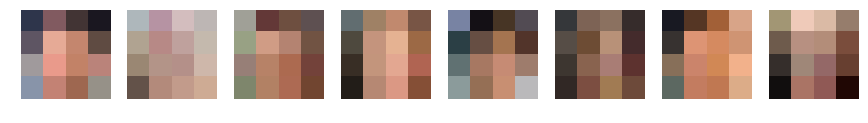

STAB. Iter:9000 errD: 0.09 errG: 0.36 in 28.23


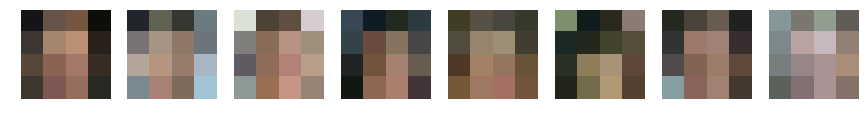

STAB. Iter:10000 errD: -0.00 errG: 0.02 in 27.46


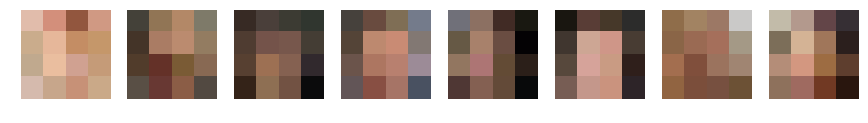

STAB. Iter:11000 errD: -0.20 errG: 0.01 in 28.47


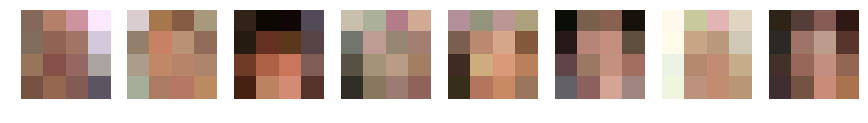

STAB. Iter:12000 errD: -0.04 errG: 0.19 in 29.16


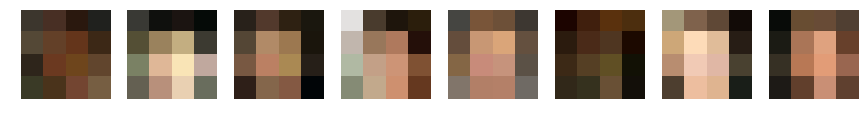

DataAcc reinit
STAB. Iter:13000 errD: -0.08 errG: 0.02 in 27.29


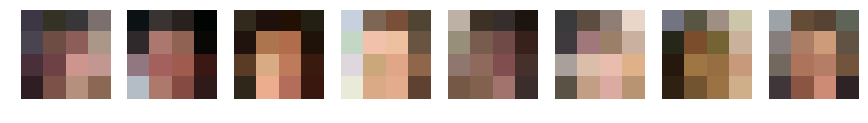

STAB. Iter:14000 errD: -0.19 errG: 0.12 in 22.59


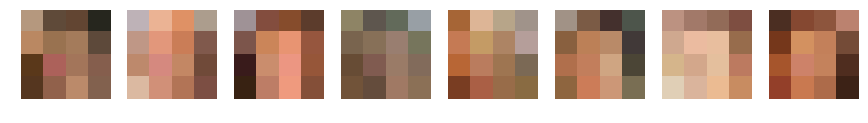

STAB. Iter:15000 errD: 0.03 errG: 0.07 in 22.63


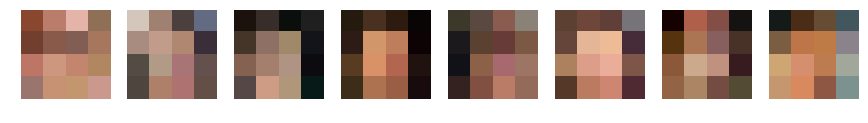

STAB. Iter:16000 errD: 0.06 errG: 0.13 in 22.58


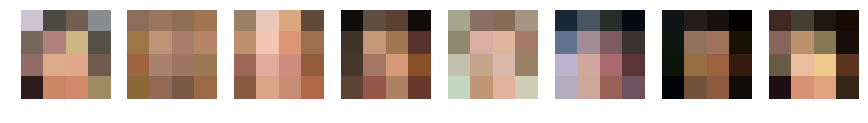

STAB. Iter:17000 errD: 0.06 errG: 0.14 in 22.59


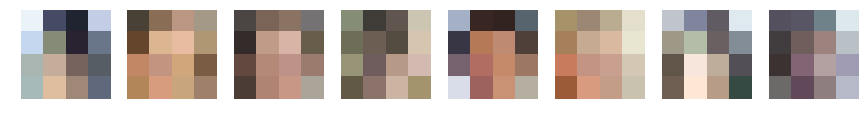

STAB. Iter:18000 errD: -0.01 errG: 0.28 in 22.57


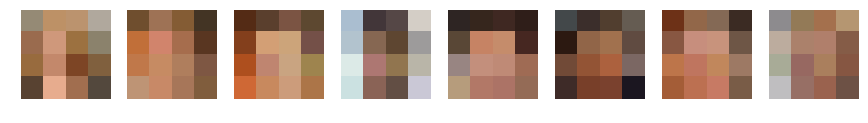

STAB. Iter:19000 errD: -0.13 errG: 0.16 in 22.62


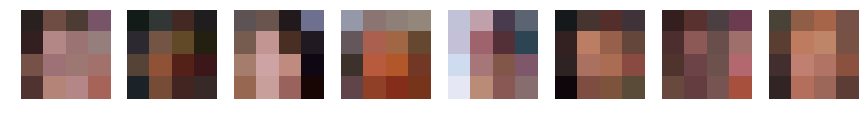

STAB. Iter:20000 errD: -0.02 errG: 0.08 in 22.68


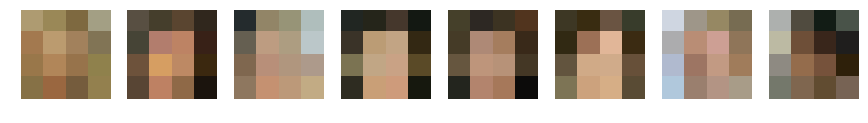

STAB. Iter:21000 errD: 0.14 errG: -0.03 in 22.97


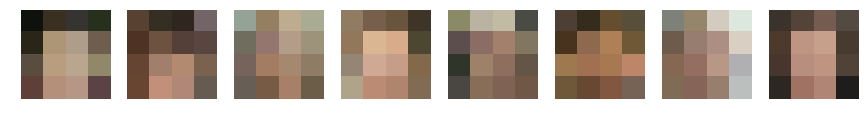

STAB. Iter:22000 errD: 0.06 errG: 0.14 in 22.84


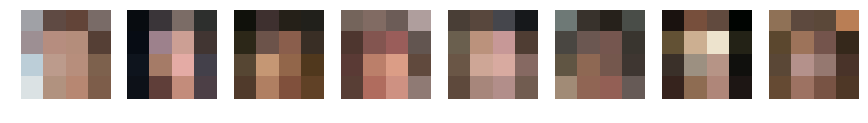

STAB. Iter:23000 errD: 0.02 errG: 0.32 in 22.75


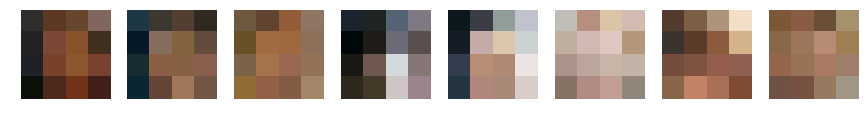

STAB. Iter:24000 errD: 0.01 errG: 0.29 in 23.43


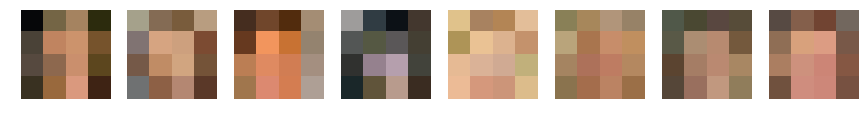

STAB. Iter:25000 errD: -0.03 errG: 0.17 in 22.89


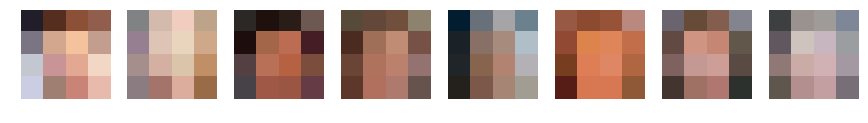

DataAcc reinit
STAB. Iter:26000 errD: -0.11 errG: 0.08 in 22.96


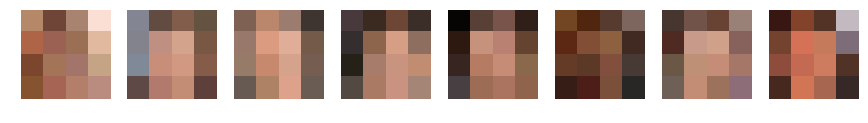

STAB. Iter:27000 errD: 0.07 errG: -0.02 in 22.84


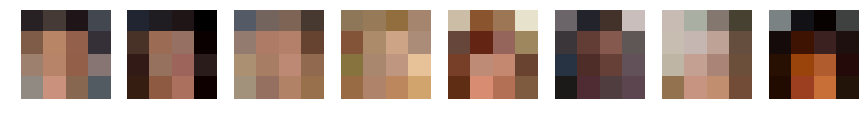

STAB. Iter:28000 errD: 0.04 errG: 0.05 in 22.78


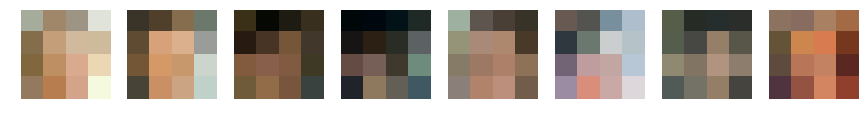

STAB. Iter:29000 errD: 0.06 errG: 0.07 in 22.89


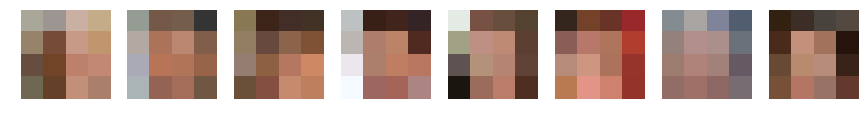

STAB. Iter:30000 errD: 0.03 errG: 0.04 in 22.75


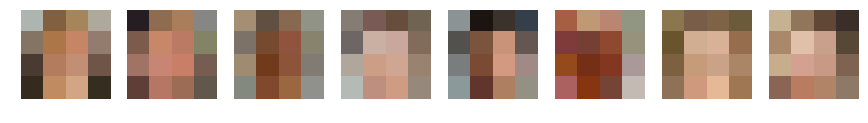

STAB. Iter:31000 errD: 0.08 errG: 0.27 in 22.88


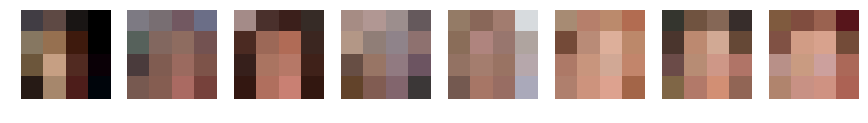

STAB. Iter:32000 errD: 0.08 errG: 0.29 in 22.89


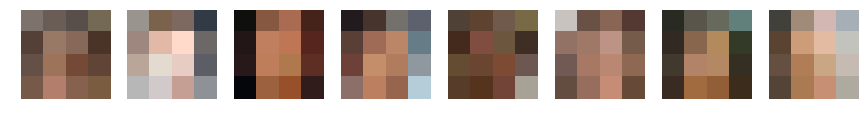

STAB. Iter:33000 errD: 0.07 errG: 0.12 in 22.90


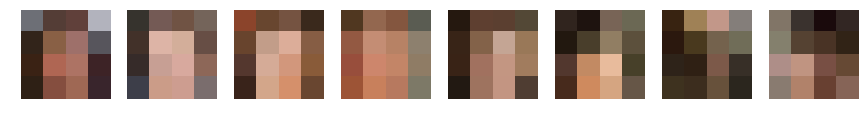

STAB. Iter:34000 errD: 0.11 errG: -0.16 in 22.74


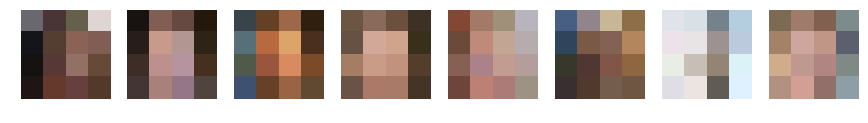

Saved checkpoint: checkpoints/1_0_35000.pth.tar
FADE. Iter:0 errD: 2.18 errG: -0.08 in 23.22


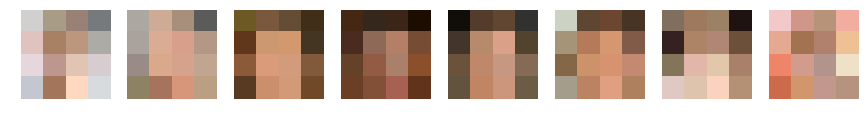

FADE. Iter:1000 errD: -2.11 errG: 1.97 in 35.42


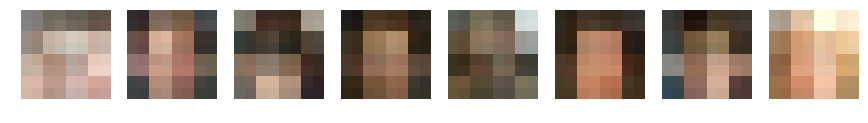

FADE. Iter:2000 errD: -0.81 errG: 1.67 in 35.29


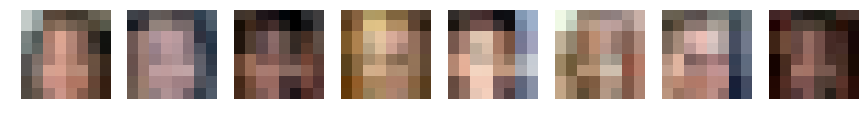

FADE. Iter:3000 errD: -0.74 errG: -1.22 in 35.28


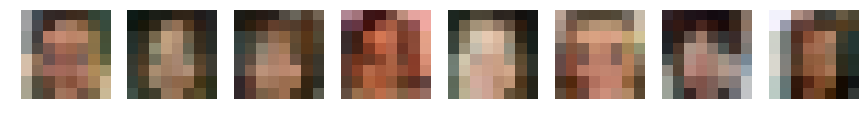

FADE. Iter:4000 errD: -0.13 errG: 0.22 in 35.27


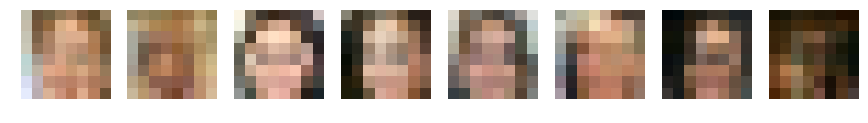

FADE. Iter:5000 errD: -0.15 errG: -0.72 in 35.39


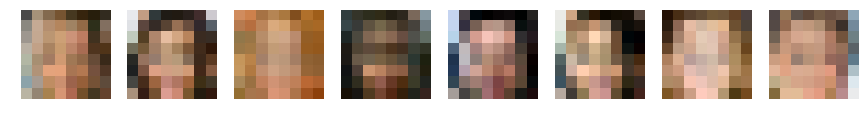

FADE. Iter:6000 errD: 0.15 errG: 0.03 in 35.25


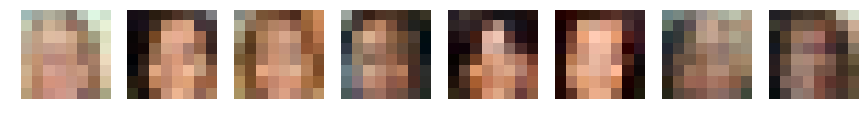

FADE. Iter:7000 errD: -0.12 errG: 0.30 in 35.82


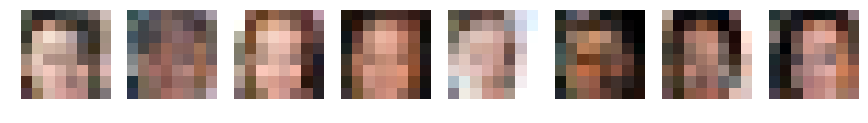

FADE. Iter:8000 errD: 0.02 errG: 0.45 in 35.28


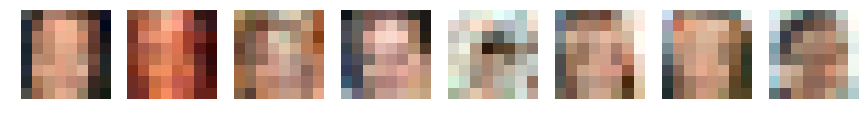

FADE. Iter:9000 errD: 0.13 errG: 0.57 in 35.22


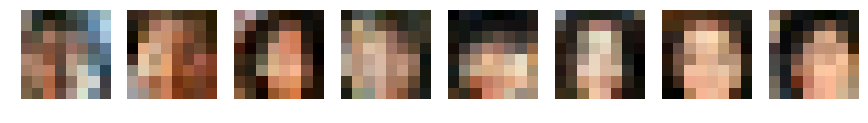

FADE. Iter:10000 errD: -0.09 errG: 0.73 in 35.47


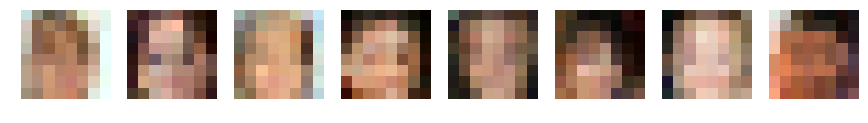

FADE. Iter:11000 errD: -0.17 errG: -0.25 in 35.15


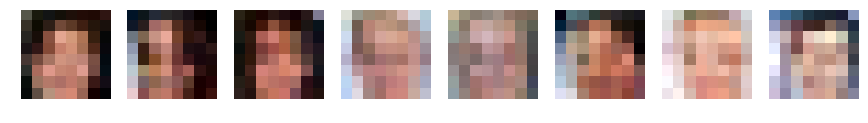

FADE. Iter:12000 errD: 0.42 errG: -0.43 in 35.34


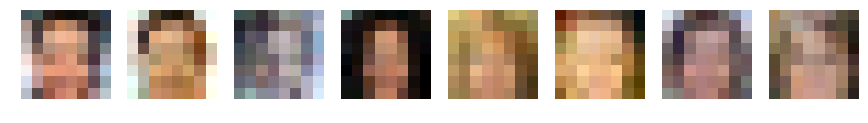

DataAcc reinit
FADE. Iter:13000 errD: 0.01 errG: 0.24 in 35.66


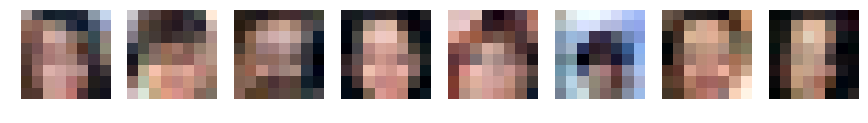

FADE. Iter:14000 errD: 0.13 errG: -0.49 in 35.17


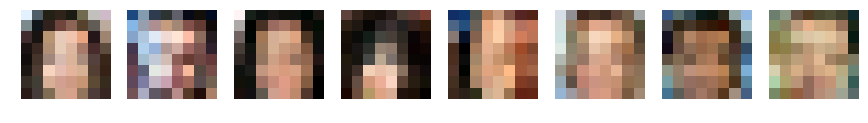

FADE. Iter:15000 errD: 0.03 errG: -0.64 in 35.35


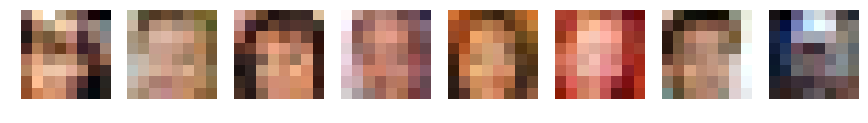

FADE. Iter:16000 errD: 0.29 errG: 0.84 in 35.43


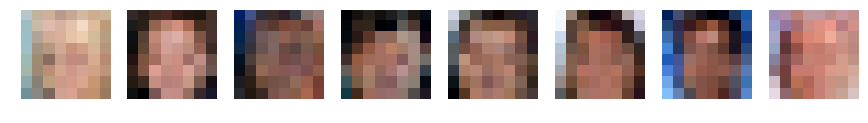

FADE. Iter:17000 errD: -0.06 errG: -0.60 in 35.30


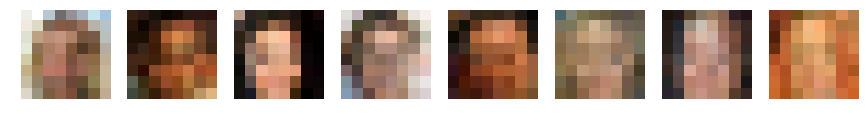

FADE. Iter:18000 errD: -0.15 errG: 1.18 in 35.27


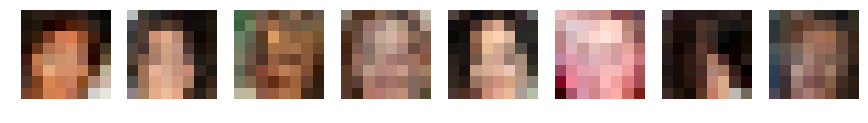

FADE. Iter:19000 errD: 0.09 errG: 0.19 in 35.51


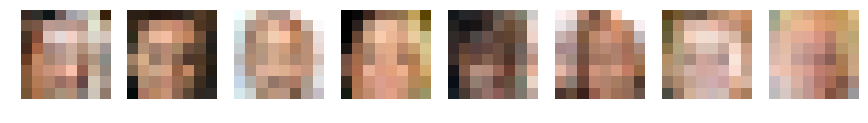

FADE. Iter:20000 errD: -0.23 errG: -0.60 in 35.43


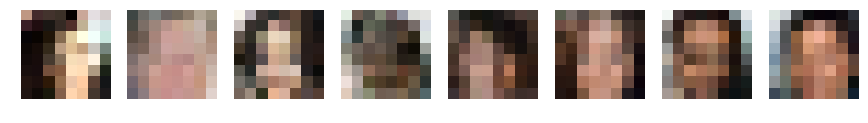

FADE. Iter:21000 errD: -0.33 errG: -0.82 in 35.25


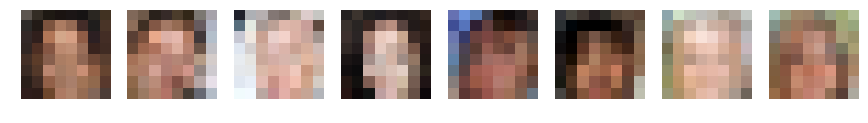

FADE. Iter:22000 errD: -0.27 errG: 0.21 in 35.21


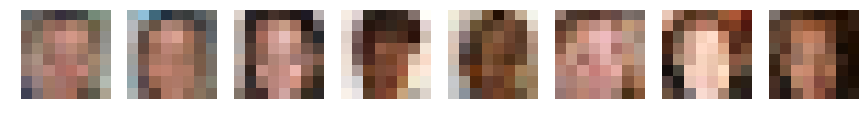

FADE. Iter:23000 errD: -0.13 errG: 0.13 in 35.53


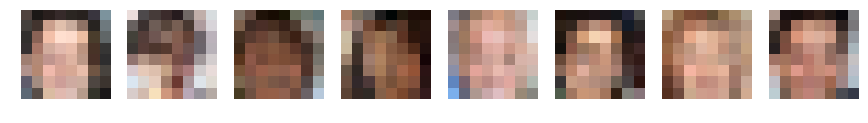

FADE. Iter:24000 errD: -0.09 errG: 0.51 in 35.36


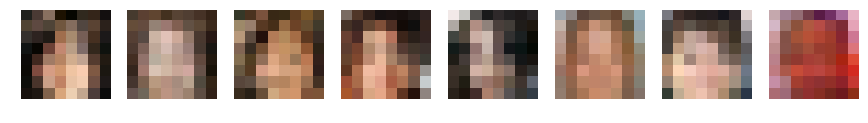

FADE. Iter:25000 errD: -0.08 errG: 0.85 in 35.29


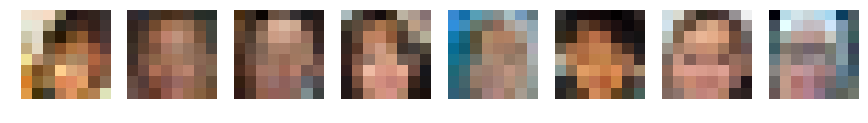

DataAcc reinit
FADE. Iter:26000 errD: -0.03 errG: 0.15 in 35.49


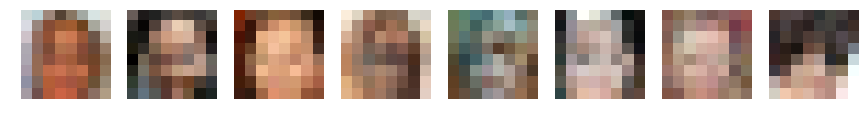

FADE. Iter:27000 errD: 0.19 errG: -0.09 in 35.07


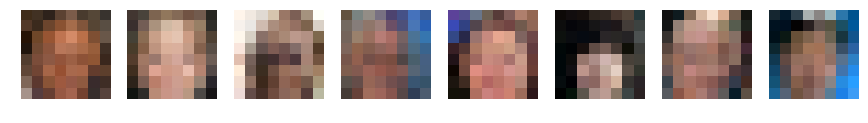

FADE. Iter:28000 errD: 0.10 errG: 0.08 in 35.09


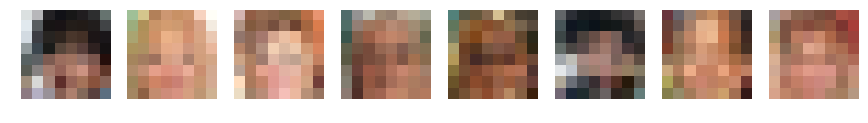

FADE. Iter:29000 errD: -0.01 errG: 0.95 in 35.46


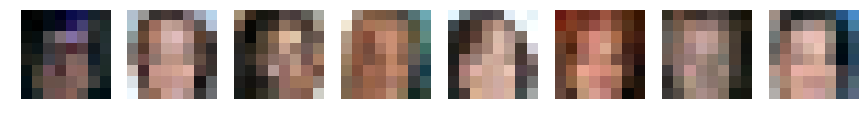

FADE. Iter:30000 errD: 0.09 errG: -0.58 in 35.31


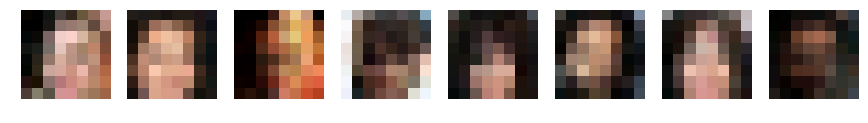

FADE. Iter:31000 errD: -0.15 errG: 0.00 in 35.35


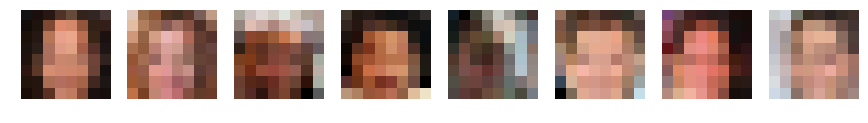

FADE. Iter:32000 errD: -0.39 errG: 0.55 in 35.23


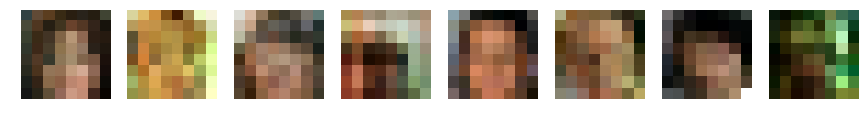

FADE. Iter:33000 errD: -0.17 errG: -0.44 in 36.59


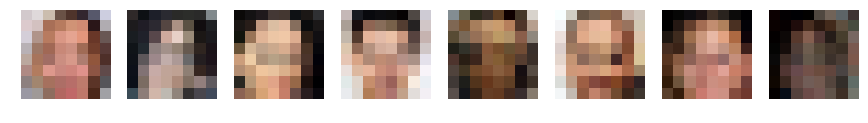

FADE. Iter:34000 errD: 0.39 errG: -0.03 in 35.59


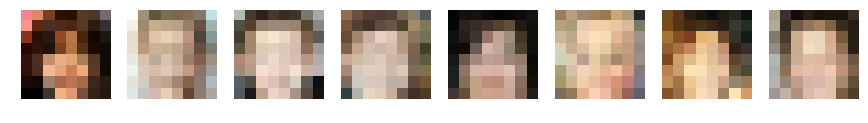

Saved checkpoint: checkpoints/1_1_35000.pth.tar
STAB. Iter:0 errD: 0.36 errG: 0.70 in 35.54


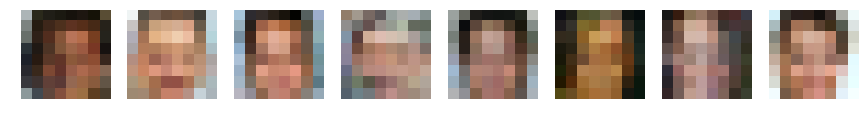

STAB. Iter:1000 errD: 0.28 errG: 0.40 in 33.65


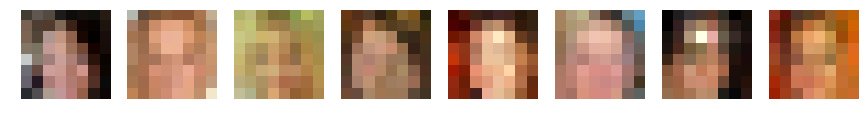

STAB. Iter:2000 errD: 0.20 errG: 0.80 in 33.77


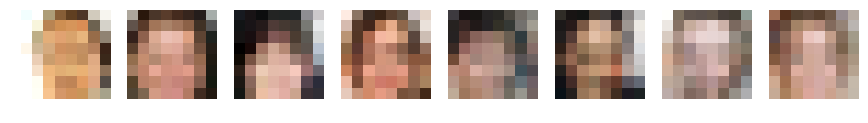

STAB. Iter:3000 errD: 0.08 errG: 0.33 in 33.82


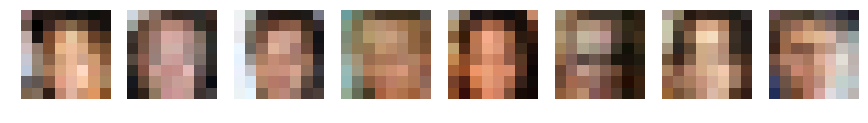

STAB. Iter:4000 errD: -0.03 errG: -0.50 in 33.68


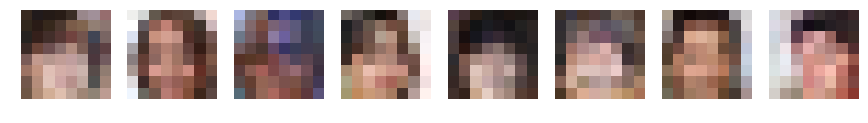

STAB. Iter:5000 errD: 0.03 errG: 0.55 in 33.72


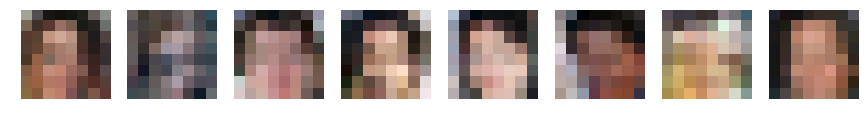

STAB. Iter:6000 errD: -0.33 errG: 0.58 in 33.61


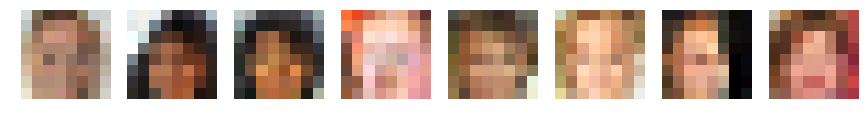

STAB. Iter:7000 errD: -0.19 errG: -0.36 in 33.69


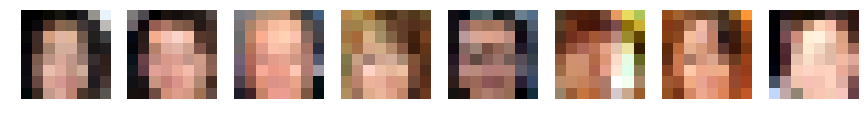

STAB. Iter:8000 errD: -0.03 errG: -0.38 in 33.57


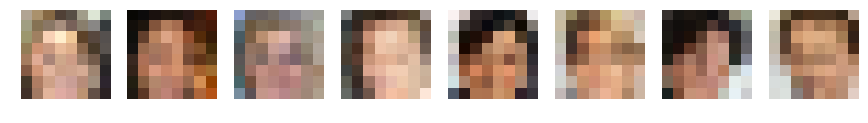

STAB. Iter:9000 errD: -0.14 errG: 0.08 in 33.75


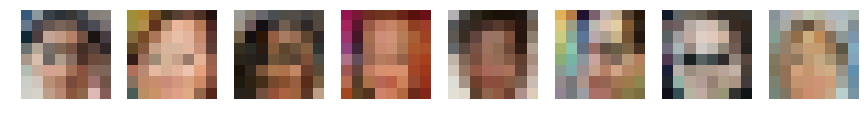

STAB. Iter:10000 errD: -0.07 errG: -0.08 in 34.00


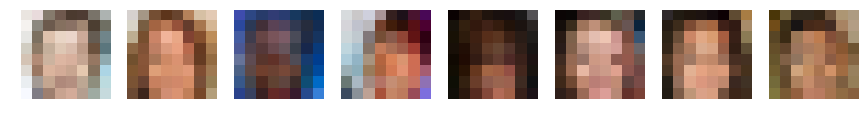

STAB. Iter:11000 errD: 0.17 errG: -0.20 in 33.57


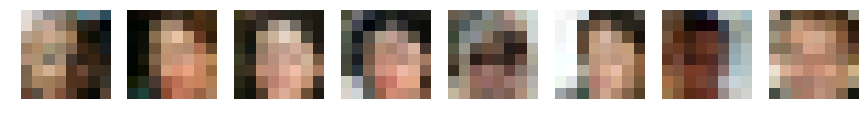

STAB. Iter:12000 errD: -0.09 errG: 0.37 in 34.26


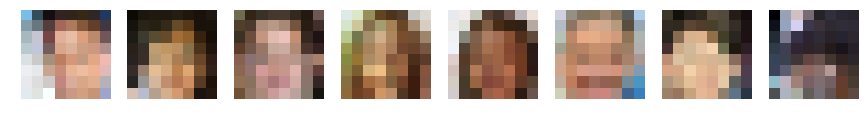

DataAcc reinit
STAB. Iter:13000 errD: 0.06 errG: -0.83 in 34.16


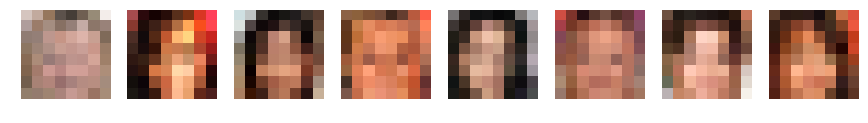

STAB. Iter:14000 errD: 0.07 errG: 0.17 in 33.59


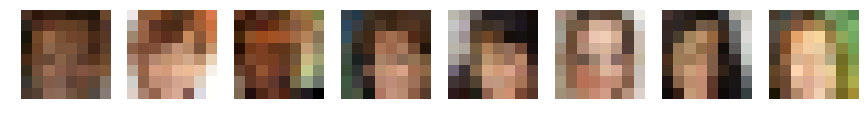

STAB. Iter:15000 errD: -0.28 errG: 0.30 in 33.75


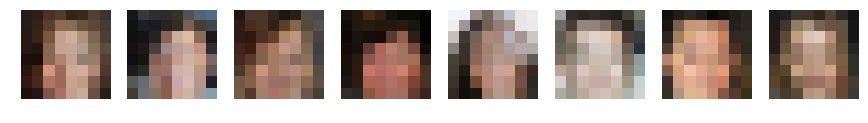

STAB. Iter:16000 errD: 0.03 errG: -0.13 in 34.21


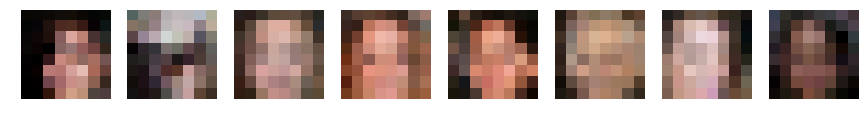

STAB. Iter:17000 errD: -0.07 errG: -0.07 in 34.06


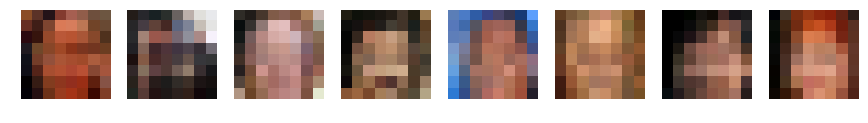

STAB. Iter:18000 errD: 0.14 errG: 0.18 in 34.21


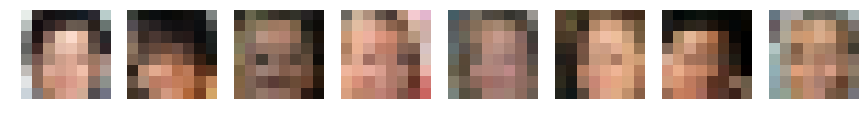

STAB. Iter:19000 errD: -0.00 errG: 0.16 in 34.23


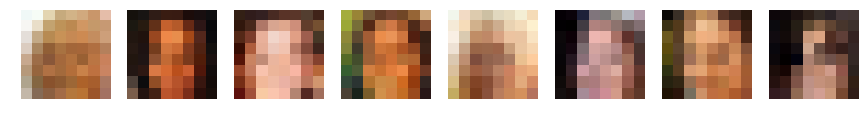

STAB. Iter:20000 errD: -0.14 errG: 0.23 in 35.16


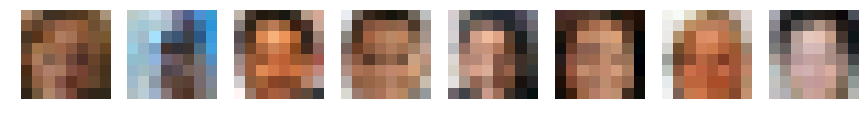

STAB. Iter:21000 errD: -0.06 errG: -0.02 in 33.43


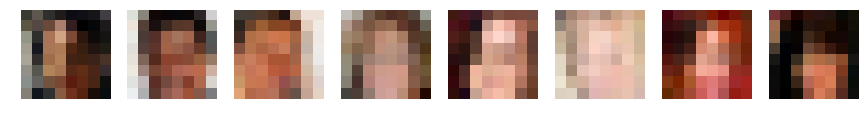

STAB. Iter:22000 errD: 0.27 errG: -0.09 in 33.96


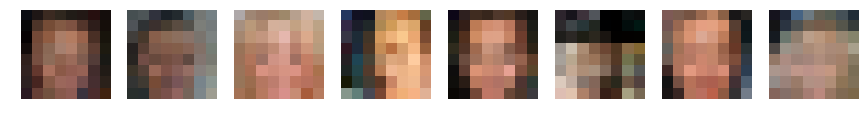

STAB. Iter:23000 errD: -0.16 errG: 0.26 in 33.70


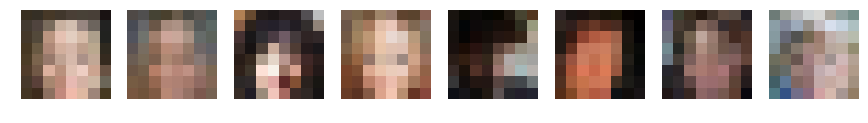

STAB. Iter:24000 errD: 0.07 errG: 0.09 in 33.42


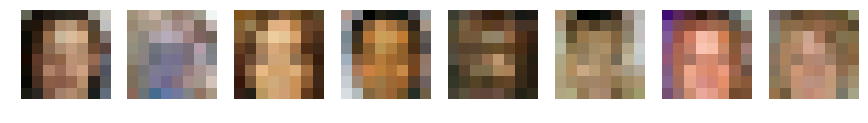

STAB. Iter:25000 errD: -0.05 errG: -0.01 in 33.54


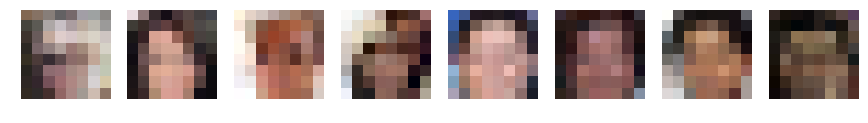

DataAcc reinit
STAB. Iter:26000 errD: -0.10 errG: -0.02 in 34.03


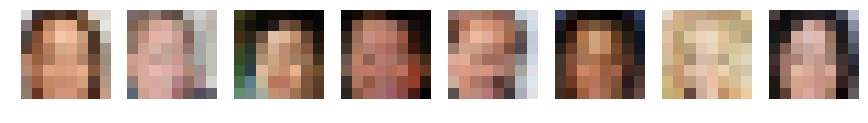

STAB. Iter:27000 errD: 0.18 errG: 0.26 in 34.10


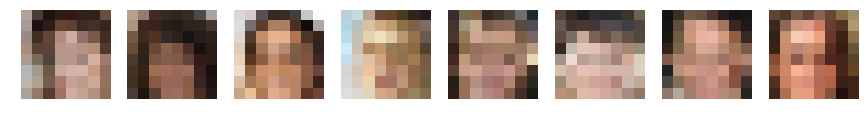

STAB. Iter:28000 errD: -0.06 errG: -0.40 in 33.62


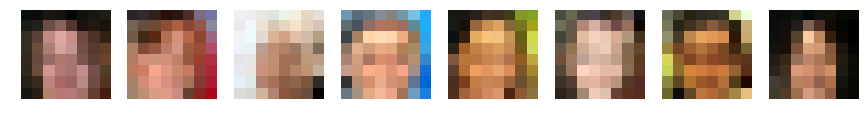

STAB. Iter:29000 errD: -0.07 errG: 0.75 in 33.91


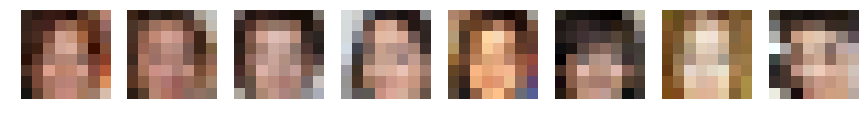

STAB. Iter:30000 errD: 0.21 errG: -0.53 in 33.76


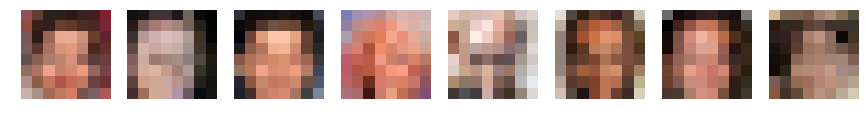

STAB. Iter:31000 errD: 0.04 errG: 0.16 in 34.51


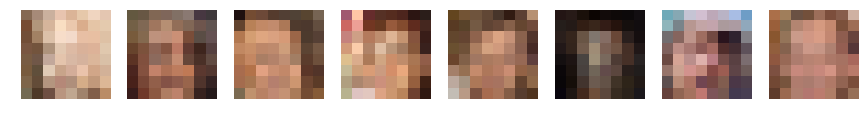

STAB. Iter:32000 errD: 0.35 errG: -0.28 in 35.53


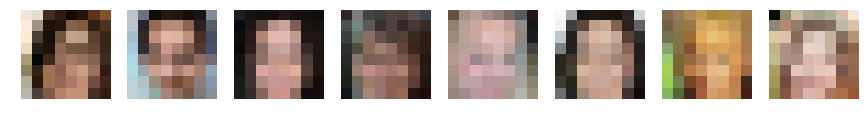

STAB. Iter:33000 errD: 0.25 errG: -0.12 in 35.65


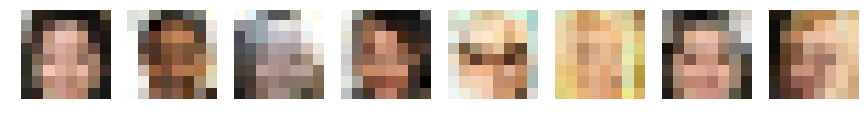

STAB. Iter:34000 errD: -0.09 errG: 0.71 in 35.46


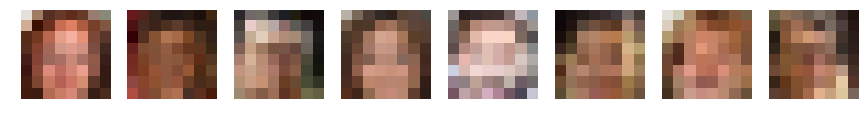

Saved checkpoint: checkpoints/2_0_35000.pth.tar
FADE. Iter:0 errD: 1.92 errG: 0.00 in 34.05


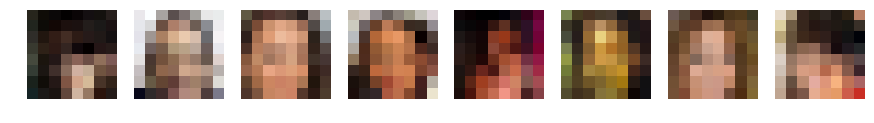

FADE. Iter:1000 errD: -2.76 errG: 5.48 in 50.15


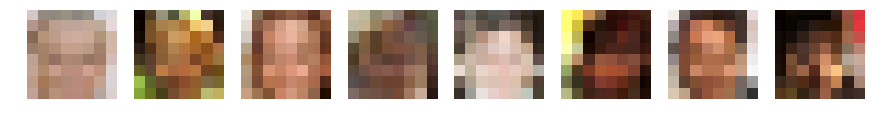

FADE. Iter:2000 errD: -2.07 errG: 3.19 in 47.79


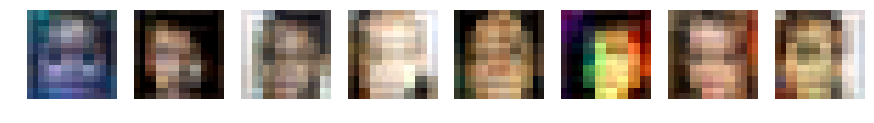

FADE. Iter:3000 errD: -0.72 errG: 5.65 in 48.18


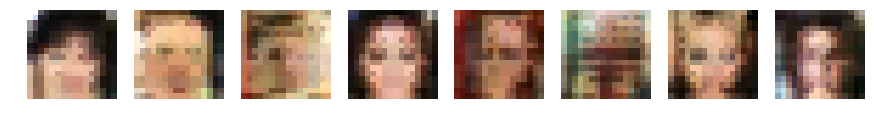

FADE. Iter:4000 errD: -0.86 errG: -2.10 in 48.12


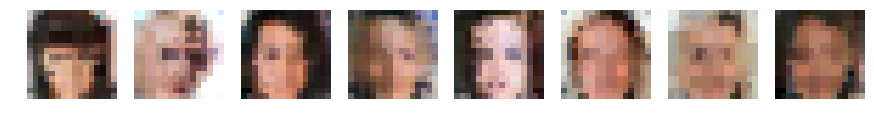

FADE. Iter:5000 errD: 0.26 errG: -4.72 in 48.22


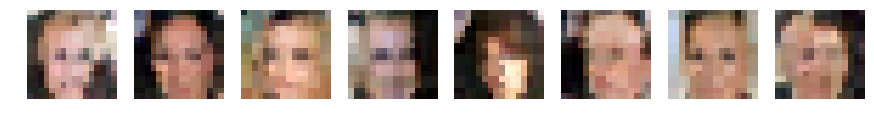

FADE. Iter:6000 errD: -0.38 errG: 1.85 in 48.23


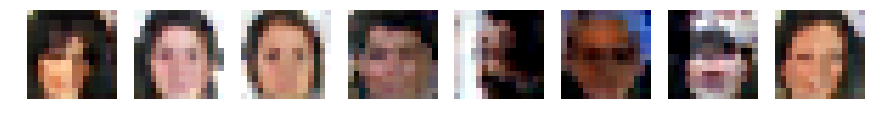

FADE. Iter:7000 errD: 0.46 errG: 3.43 in 48.31


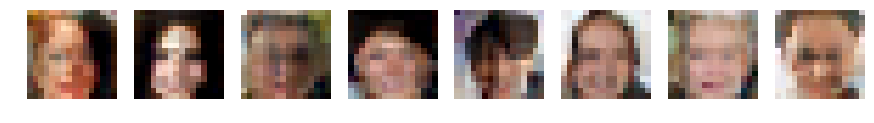

FADE. Iter:8000 errD: 0.30 errG: 0.35 in 48.51


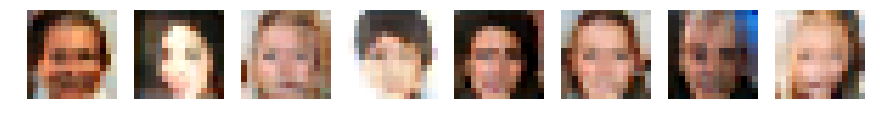

FADE. Iter:9000 errD: 0.60 errG: -1.51 in 49.08


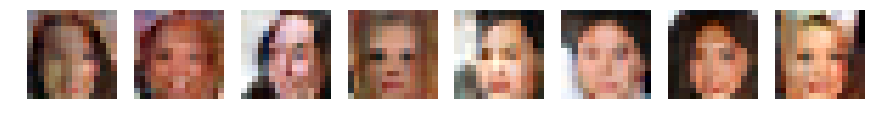

FADE. Iter:10000 errD: 0.11 errG: 0.83 in 48.32


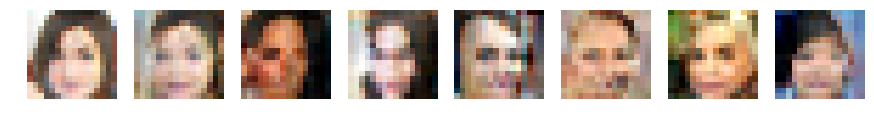

FADE. Iter:11000 errD: 0.14 errG: 2.35 in 48.42


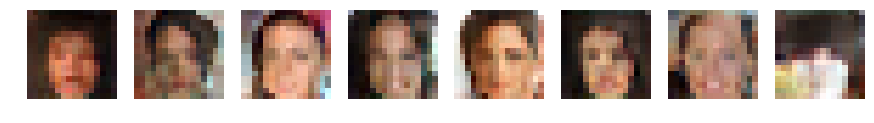

FADE. Iter:12000 errD: -0.30 errG: 0.39 in 49.81


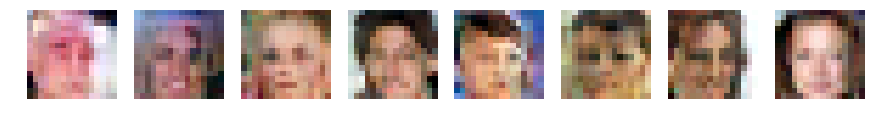

DataAcc reinit
FADE. Iter:13000 errD: -0.05 errG: -0.85 in 48.57


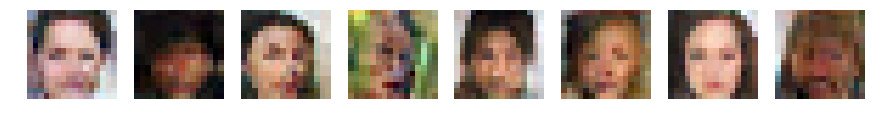

FADE. Iter:14000 errD: -0.01 errG: 1.41 in 47.85


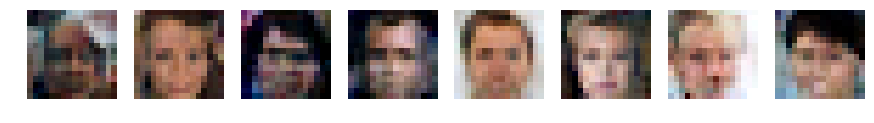

FADE. Iter:15000 errD: -0.19 errG: -0.66 in 47.80


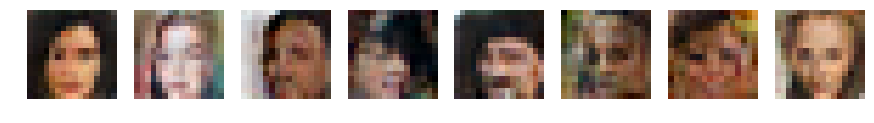

FADE. Iter:16000 errD: -0.09 errG: 1.37 in 47.57


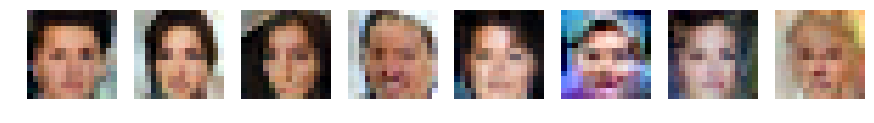

FADE. Iter:17000 errD: 0.37 errG: 1.31 in 48.03


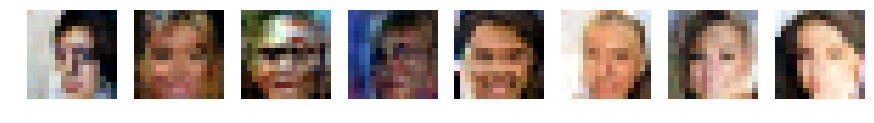

FADE. Iter:18000 errD: -0.01 errG: -0.81 in 48.06


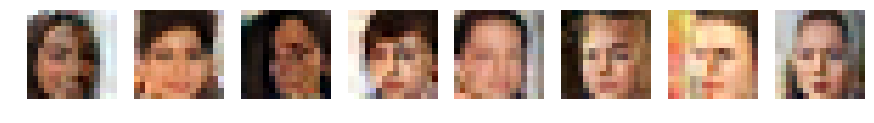

FADE. Iter:19000 errD: -0.46 errG: -1.08 in 47.70


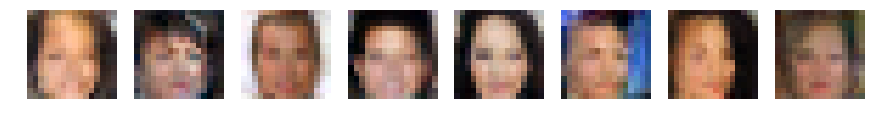

FADE. Iter:20000 errD: -0.03 errG: -0.38 in 47.88


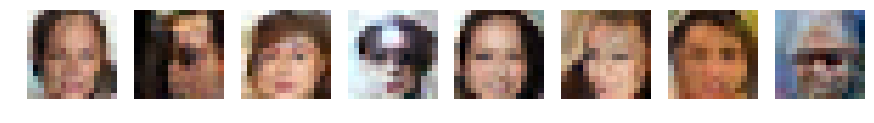

FADE. Iter:21000 errD: -0.03 errG: -1.08 in 47.50


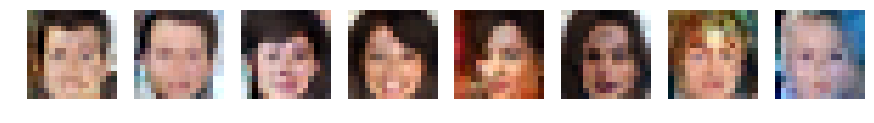

FADE. Iter:22000 errD: 0.27 errG: 2.14 in 47.86


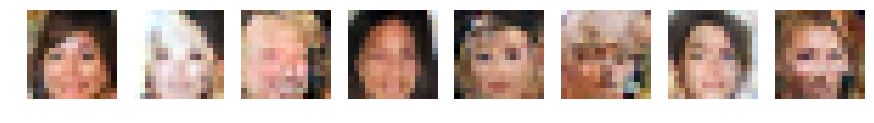

FADE. Iter:23000 errD: -0.23 errG: 1.58 in 47.93


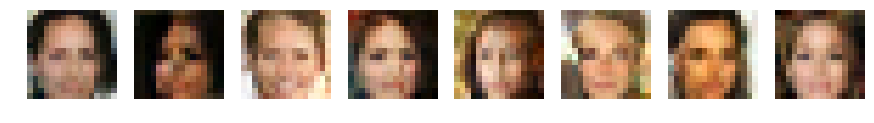

FADE. Iter:24000 errD: 0.15 errG: 2.57 in 47.92


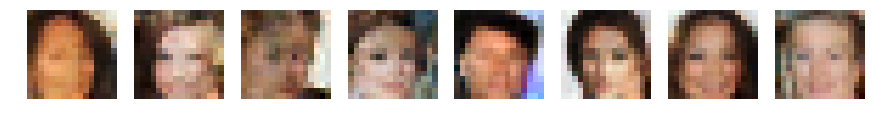

FADE. Iter:25000 errD: -0.23 errG: -0.31 in 47.87


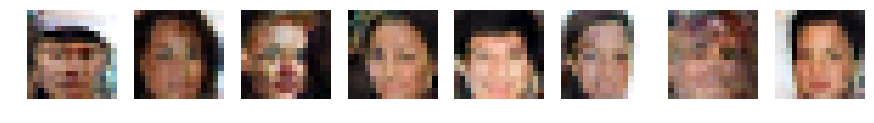

DataAcc reinit
FADE. Iter:26000 errD: -0.28 errG: -0.01 in 48.17


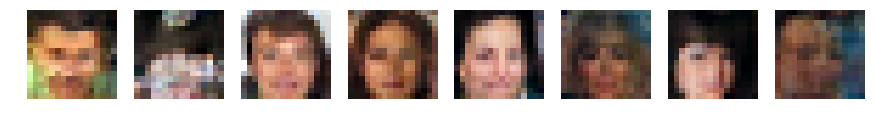

FADE. Iter:27000 errD: 0.17 errG: 1.79 in 47.65


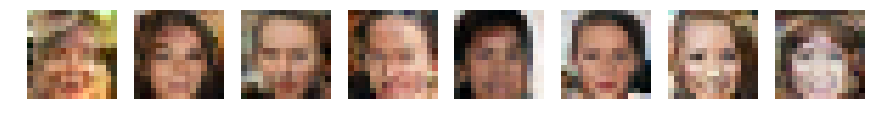

FADE. Iter:28000 errD: 0.15 errG: -1.01 in 47.89


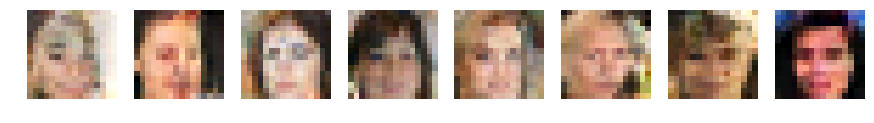

FADE. Iter:29000 errD: -0.28 errG: 2.06 in 47.95


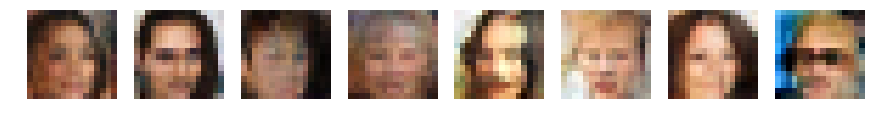

FADE. Iter:30000 errD: -0.35 errG: -0.01 in 48.42


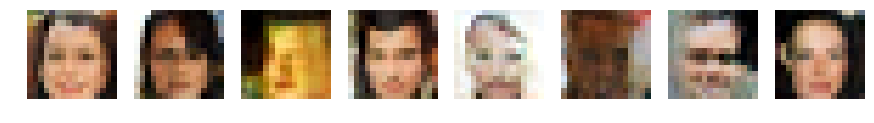

FADE. Iter:31000 errD: -0.31 errG: 1.21 in 47.80


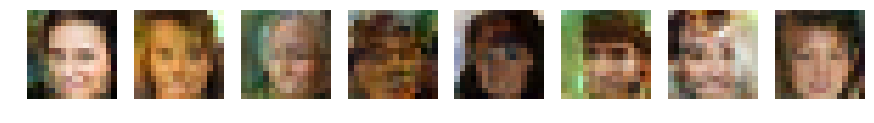

FADE. Iter:32000 errD: -0.18 errG: 0.51 in 48.02


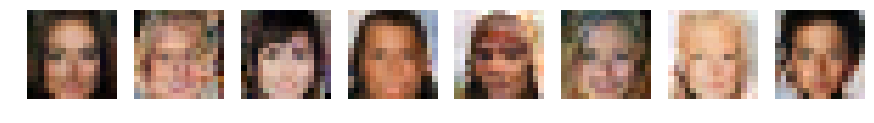

FADE. Iter:33000 errD: 0.01 errG: -0.74 in 47.72


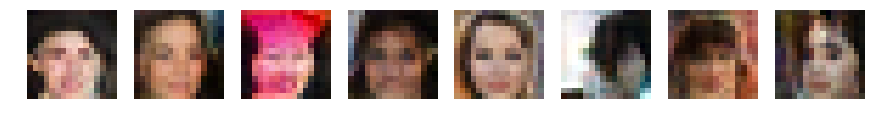

FADE. Iter:34000 errD: 0.20 errG: 0.31 in 47.59


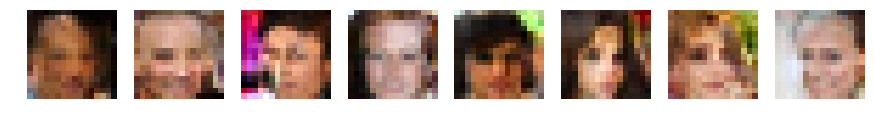

Saved checkpoint: checkpoints/2_1_35000.pth.tar
STAB. Iter:0 errD: -0.45 errG: 0.37 in 48.14


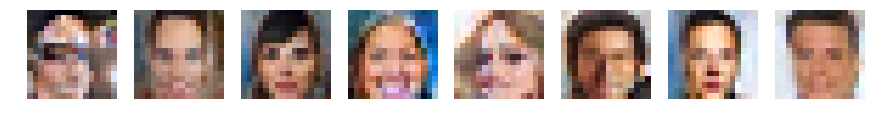

STAB. Iter:1000 errD: 0.00 errG: 0.37 in 46.38


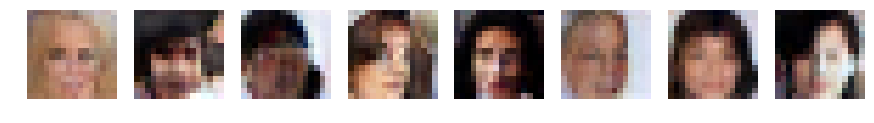

STAB. Iter:2000 errD: -0.37 errG: -0.19 in 46.94


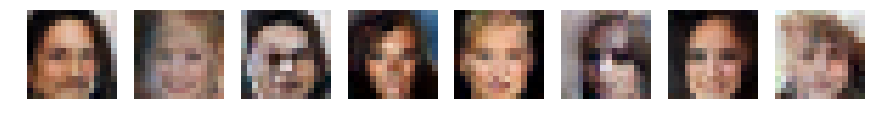

STAB. Iter:3000 errD: -0.12 errG: 1.24 in 45.65


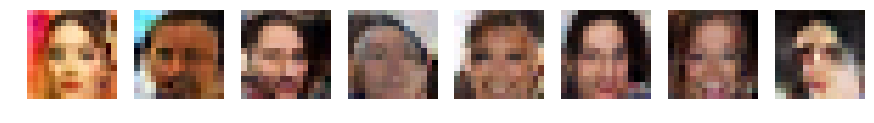

STAB. Iter:4000 errD: -0.64 errG: -0.95 in 45.67


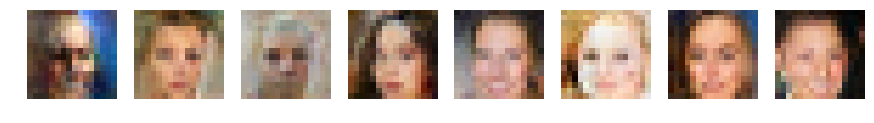

STAB. Iter:5000 errD: -0.37 errG: 0.76 in 45.75


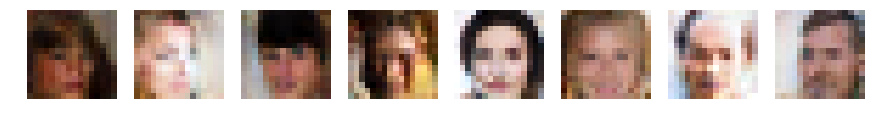

STAB. Iter:6000 errD: 0.39 errG: -0.05 in 46.09


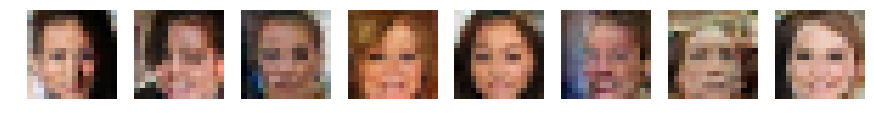

STAB. Iter:7000 errD: 0.07 errG: -0.54 in 45.69


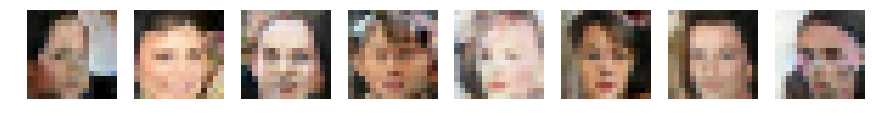

STAB. Iter:8000 errD: -0.27 errG: -0.47 in 46.13


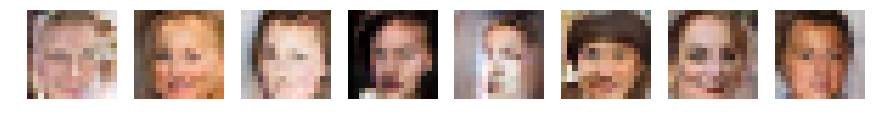

STAB. Iter:9000 errD: -0.32 errG: 0.90 in 46.35


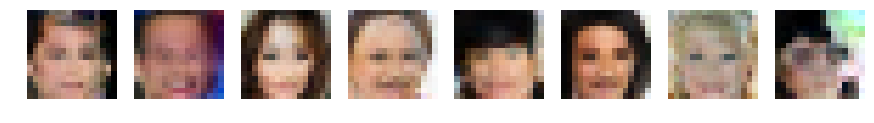

STAB. Iter:10000 errD: -0.28 errG: 0.66 in 45.65


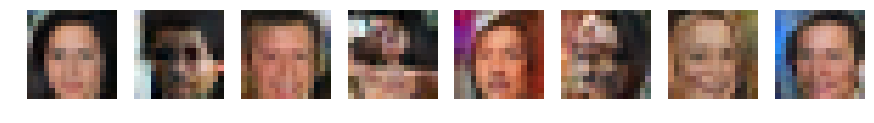

STAB. Iter:11000 errD: -0.53 errG: 0.55 in 47.26


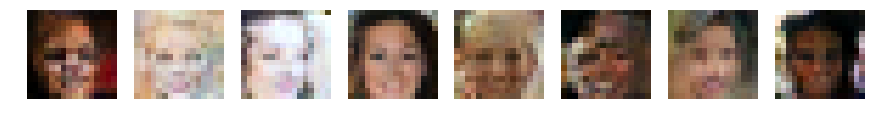

STAB. Iter:12000 errD: -0.21 errG: 1.05 in 46.33


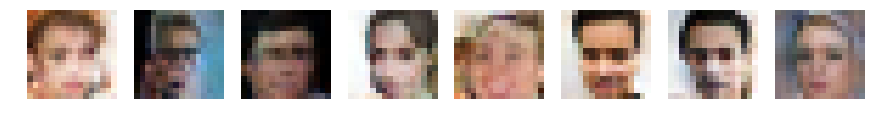

DataAcc reinit
STAB. Iter:13000 errD: 0.59 errG: -0.60 in 46.95


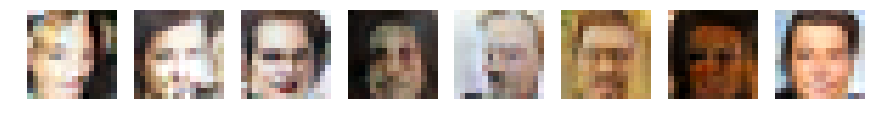

STAB. Iter:14000 errD: -0.32 errG: -0.21 in 46.08


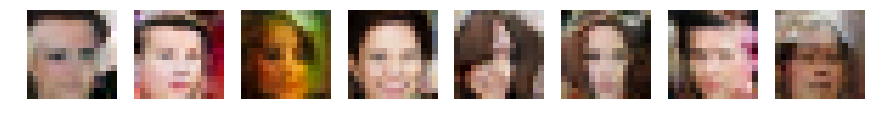

STAB. Iter:15000 errD: 0.11 errG: 0.93 in 47.84


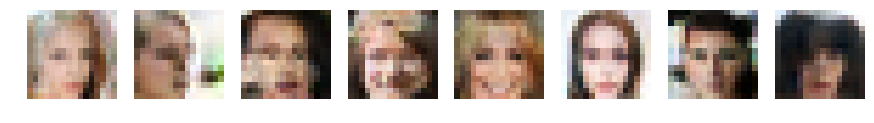

STAB. Iter:16000 errD: -0.40 errG: -0.01 in 46.70


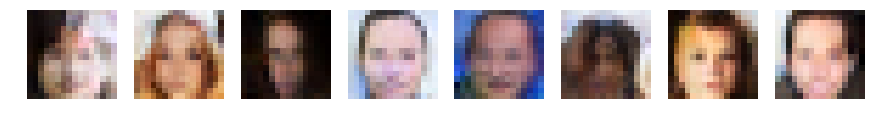

STAB. Iter:17000 errD: -0.54 errG: 1.22 in 46.40


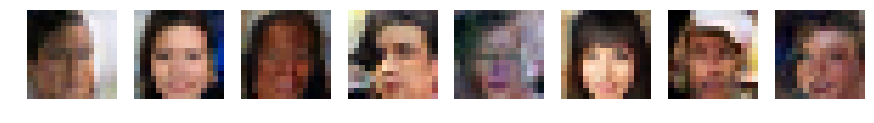

STAB. Iter:18000 errD: -0.03 errG: 0.08 in 45.95


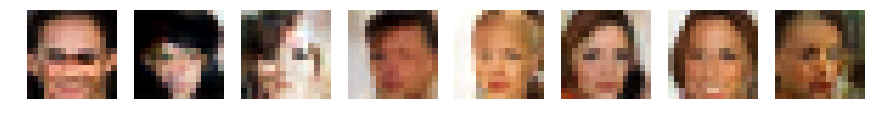

STAB. Iter:19000 errD: -0.43 errG: 0.77 in 46.03


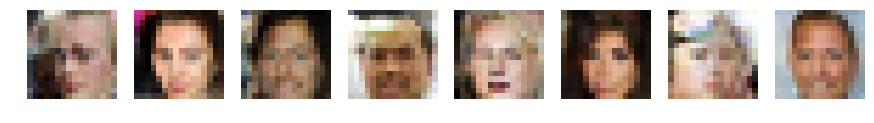

STAB. Iter:20000 errD: 0.04 errG: 1.31 in 46.12


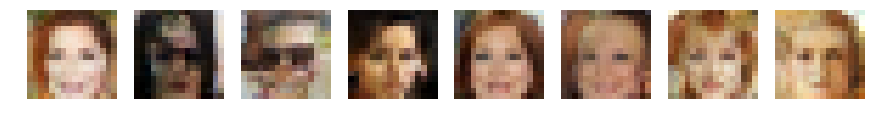

STAB. Iter:21000 errD: -0.15 errG: 0.64 in 45.90


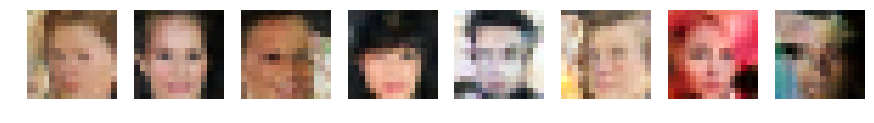

STAB. Iter:22000 errD: 0.57 errG: 1.36 in 46.20


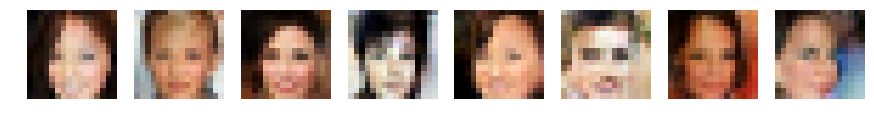

STAB. Iter:23000 errD: -0.30 errG: 0.99 in 45.94


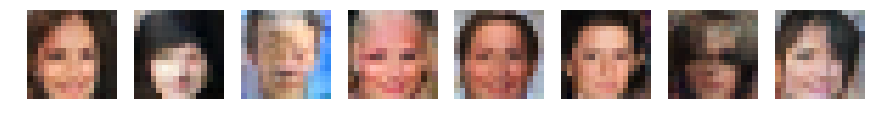

STAB. Iter:24000 errD: -0.43 errG: 0.77 in 46.19


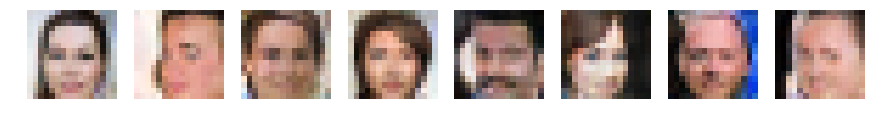

STAB. Iter:25000 errD: -0.03 errG: -0.17 in 45.96


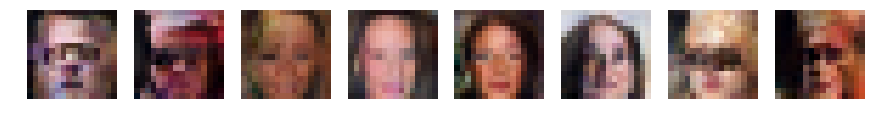

DataAcc reinit
STAB. Iter:26000 errD: 0.01 errG: -0.34 in 46.19


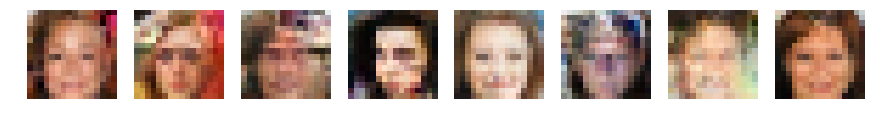

STAB. Iter:27000 errD: -0.20 errG: 0.74 in 45.78


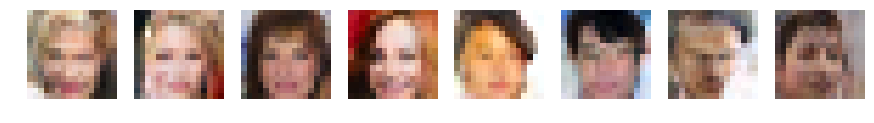

STAB. Iter:28000 errD: -0.21 errG: 1.00 in 46.17


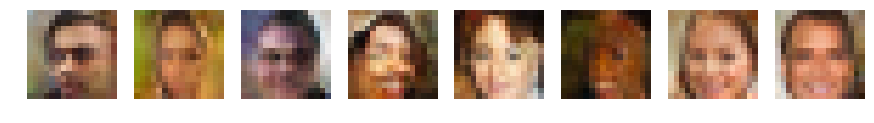

STAB. Iter:29000 errD: 0.30 errG: 1.06 in 46.03


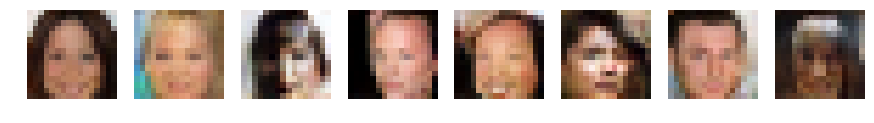

STAB. Iter:30000 errD: -0.29 errG: 0.52 in 46.04


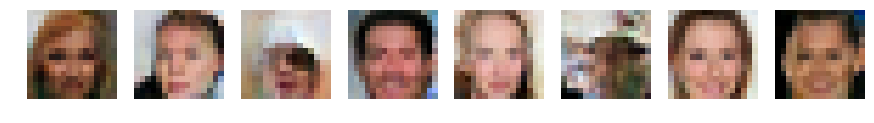

STAB. Iter:31000 errD: -0.28 errG: -0.40 in 46.62


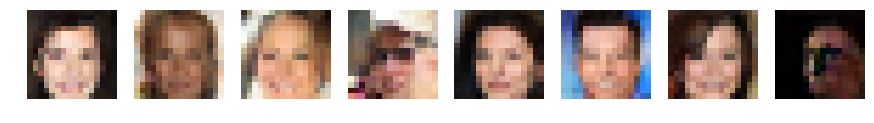

STAB. Iter:32000 errD: -0.09 errG: 0.49 in 50.87


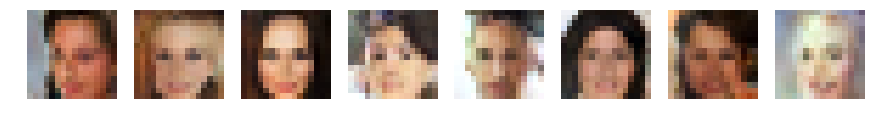

STAB. Iter:33000 errD: -0.13 errG: 0.64 in 50.87


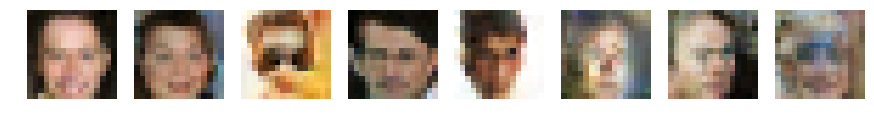

STAB. Iter:34000 errD: -0.03 errG: -0.54 in 50.89


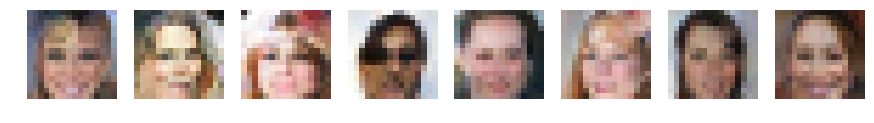

Saved checkpoint: checkpoints/3_0_35000.pth.tar
FADE. Iter:0 errD: 1.86 errG: -0.84 in 50.64


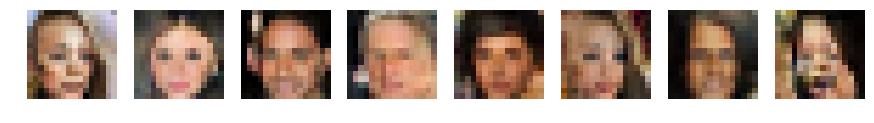

FADE. Iter:1000 errD: -1.56 errG: 3.01 in 76.50


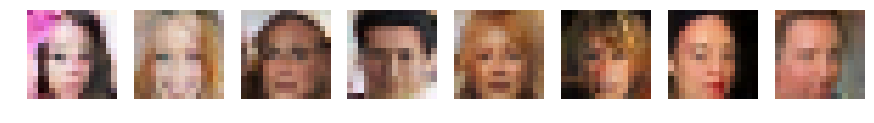

Process Process-76:
Process Process-74:
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
Process Process-75:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-73:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/user/Documents/MachineLearning/mlenv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/user/Documents/

In [24]:
# for Rr in range(2, 8):
#     l = torch.mean(generator(NOISE, Rr)) * 1e-20
#     l.backward()
#     optim_G.step()
#     l = torch.mean(discriminator(generator(NOISE, Rr), Rr)) * 1e-20
#     l.backward()
#     optim_D.step()

stage_to_str = ['FADE', 'STAB']
timer = Timer()

while stairs <= TOWER_HEIGHT:
    if stairs >= 4:
        celeba_dataset.preload = False
    else:
        celeba_dataset.preload = True
    data_acc.reset()
    for iteration in range(n_iter):
        alpha = (iteration / n_iter) if stage == 0 else None
        
        errD = train_discriminator(generator, discriminator, optim_D,
                        NOISE, GP_ALPHA, stairs, alpha)
    
        errG = train_generator(generator, discriminator, optim_G,
                    NOISE, stairs, alpha)
        
    
        if iteration % print_every == 0:
            NOISE.data.normal_()
            print(stage_to_str[stage] + '. Iter:{} errD: {:.2f} errG: {:.2f} in {:.2f}'.format(iteration,
                                                                                               errD,
                                                                                               errG,
                                                                                               timer.tick()
                                                                                              ))
            show((generator(NOISE, stairs, alpha) + 1) / 2, 8)
#             show((generator_av(NOISE.cpu(), R, alpha) + 1) / 2, 8)
    stairs += stage
    stage = 1 - stage
    
    save_checkpoint({
        'stairs': stairs,
        'stage': stage,
        'gen': generator.state_dict(),
        'dis': discriminator.state_dict(),
        'optim_G': optim_G.state_dict(),
        'optim_D': optim_D.state_dict(),
        'n_iter': n_iter,
        'print_every': print_every,
    })

In [48]:
NOISE.data.normal_()
show((generator(NOISE, 6) + 1) / 2, 16, square=True)

IndexError: index 5 is out of range

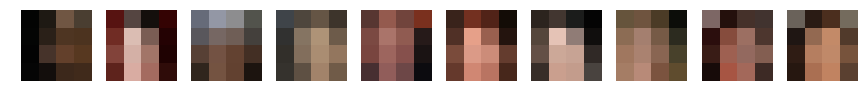

In [198]:
Rr = checkpoint({
                'R': R,
                'stage': stage,
                'gen': generator.state_dict(),
                'dis': discriminator.state_dict(),
                'optim_G': optim_G.state_dict(),
                'optim_D': optim_D.state_dict(),
                'n_iter': n_iter,
                'print_every': print_every,
                'max_R': max_R
            }, path='d
X = Variable(data_acc.get_next(), requires_grad=False).permute(0, 3, 1, 2).float()
X = nn.AvgPool2d(2**(7 - Rr))(X)
X = X.data.permute(0, 2, 3, 1).numpy()
plt.figure(figsize=(15, 7))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X[i].reshape(2**Rr, 2**Rr, 3))
    plt.axis('off')
plt.show()

In [23]:
def mean_L2(t):
    return torch.mean(t ** 2)

def print_generator_info(gen):
    print('=' * 10 + ' GENERATOR ' + '=' * 10)
    
    print('first_block_1: ' + str(mean_L2(gen.first_block[0].weight.data))
         + ' / grad: ' + str(mean_L2(gen.first_block[0].weight.grad.data)))
    print('first_block_2: ' + str(mean_L2(gen.first_block[3].weight.data))
         + ' / grad: ' + str(mean_L2(gen.first_block[3].weight.grad.data)))
    
    for i, c in enumerate(gen.to_rgb):
        print('to_rgb_' + str(i) + ': ' + str(mean_L2(c.weight.data))
             + ' / grad: ' + str(mean_L2(c.weight.grad.data)))
    
    for i, seq in enumerate(gen.iter_blocks):
        print('iter_blocks_' + str(i) + '_1: ' + str(mean_L2(seq[0].weight.data))
             + ' / grad: ' + str(mean_L2(seq[0].weight.grad.data)))
        print('iter_blocks_' + str(i) + '_2: ' + str(mean_L2(seq[3].weight.data))
             + ' / grad: ' + str(mean_L2(seq[3].weight.grad.data)))
        
def print_discriminator_info(dis):
    print('=' * 10 + ' DISCRIMINATOR ' + '=' * 10)
    
    for i, c in enumerate(dis.from_rgb):
        print('from_rgb_' + str(i) + ': ' + str(mean_L2(c[0].weight.data))
             + ' / grad: ' + str(mean_L2(c[0].weight.grad.data)))
        
    for i, seq in enumerate(dis.iter_blocks):
        print('iter_blocks_' + str(i) + '_1: ' + str(mean_L2(seq[0].weight.data))
             + ' / grad: ' + str(mean_L2(seq[0].weight.grad.data)))
        print('iter_blocks_' + str(i) + '_2: ' + str(mean_L2(seq[2].weight.data))
             + ' / grad: ' + str(mean_L2(seq[2].weight.grad.data)))
        
    print('final_conv_1: ' + str(mean_L2(dis.final_conv[0].weight.data))
         + ' / grad: ' + str(mean_L2(dis.final_conv[0].weight.grad.data)))
    print('final_conv_2: ' + str(mean_L2(dis.final_conv[2].weight.data))
         + ' / grad: ' + str(mean_L2(dis.final_conv[2].weight.grad.data)))
    
    print('pred: ' + str(mean_L2(dis.pred.weight.data))
         + ' / grad: ' + str(mean_L2(dis.pred.weight.grad.data)))
    
def print_gd_info(g, d):
    print_generator_info(g)
    print_discriminator_info(d)